In [1]:
import drawsvg as dw
from os import listdir
dir = '/home/jh/src/svg/lib'
files = listdir(dir)
for file in files:
    if file[-3:] == '.py':
        f = '%s/%s' % (dir,file)
        exec(open(f).read())

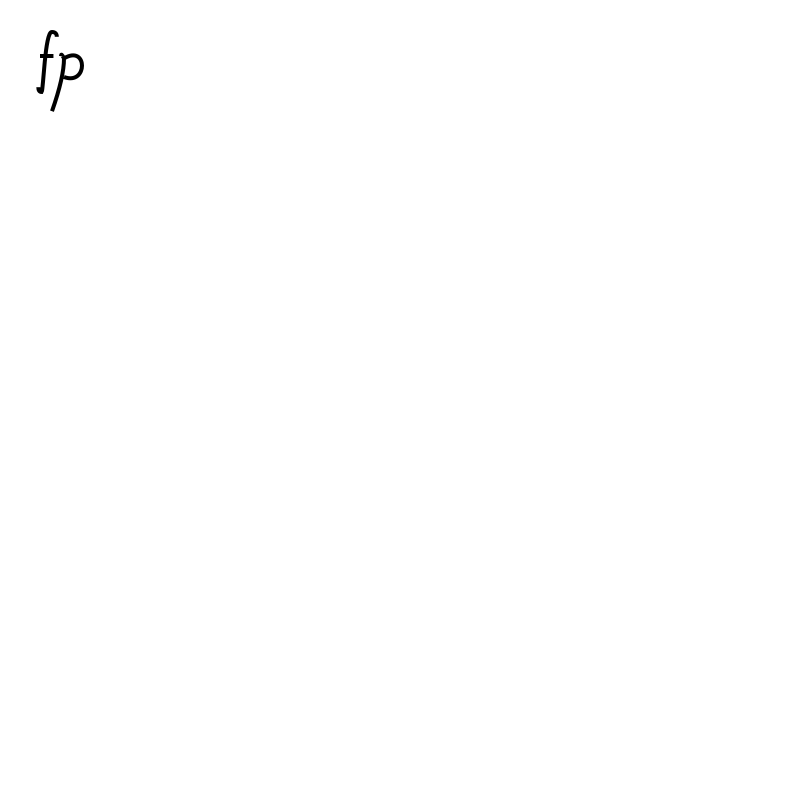

In [11]:
d = dw.Drawing(200,200)

def fortepiano(x=10,y=20,siz=12,c='black',swfac=1,**args):
    x2 = x+siz/2
    forte(x,y,siz,c,swfac,**args)
    piano(x2,y,siz,c,swfac,**args)


fortepiano()

d.set_pixel_scale(4)
#d.save_png('varVib.png')
#d.save_svg('varVib.svg')
d